# Raw Data Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import seaborn as sns

from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
tn = pd.read_csv('../zippedData/tn.movie_budgets.csv.gz')
bom = pd.read_csv('../zippedData/bom.movie_gross.csv.gz')
tmdb = pd.read_csv('../zippedData/tmdb.movies.csv.gz', index_col = 0)
title_akas = pd.read_csv('../zippedData/imdb.title.akas.csv.gz')

In [3]:
# Checking TN database

In [4]:
tn.head(5)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [5]:
tn.isnull().sum()

id                   0
release_date         0
movie                0
production_budget    0
domestic_gross       0
worldwide_gross      0
dtype: int64

In [6]:
# Function to strip dollar sign ($) and "," from the money category.
def strip_commas_dollars(dataframe, col):
    '''Strips commas and dollar sign from a column and replaces the original inplace as a str.
    
    dataframe = dataframe
    col = the col that requires stripping of both commas and dollar sign
    
    Example: $123,456 will be replaced with 123456 '''
    
    x = []
    for value in dataframe[col]:
        x.append(value.replace("$","").replace(",",""))
    dataframe[col] = x

In [7]:
#passing the function in the dataframe
strip_commas_dollars(tn, "domestic_gross")
strip_commas_dollars(tn, "worldwide_gross")
strip_commas_dollars(tn, "production_budget")

In [8]:
#Converting the money category to integers. 
tn.domestic_gross= tn.domestic_gross.astype(int)

tn.production_budget=tn.production_budget.astype(int)

tn.worldwide_gross=tn.worldwide_gross.astype(int)


#Changing release_date to datetime series
tn.release_date = pd.to_datetime(tn.release_date)
#Converting "year" column in tn to int 
tn["year"]=tn.release_date.dt.strftime("%Y").astype(int)

tn2 = tn.copy()

In [9]:
#only taking years greater than 2009 but less than 2019 to merge with bom and tmdb.
tn=tn[(tn.year>2009) & (tn.year<2019)]

In [10]:
tn.drop(columns = ["domestic_gross", "worldwide_gross", "year", "id", "release_date"], inplace=True)

In [11]:
bom.columns

Index(['title', 'studio', 'domestic_gross', 'foreign_gross', 'year'], dtype='object')

In [12]:
tmdb.columns

Index(['genre_ids', 'id', 'original_language', 'original_title', 'popularity',
       'release_date', 'title', 'vote_average', 'vote_count'],
      dtype='object')

In [13]:
# Bom and TMDB data cleaning

#We will merge on to Bom since this has a smaller shape. 
#However, we will be losing a lot of data from tmdb due to an inner join. 

In [14]:
#droppping unnecessary titles
tmdb.drop(columns = ["id", "genre_ids", "original_title"], axis = 1, inplace = True)
#merge
bom_tmdb=bom.merge(tmdb, how = "inner", on = "title")

In [15]:
#Acknowledging that we lost 684 rows from bom data. 
#However, it is crucial that we have no NaN values for all rows. 
#Merging bom_tmdb with tn. 

In [16]:
#merging tn database to bom_tmdb (box mojo office and the movie data base)
movie_db=bom_tmdb.merge(tn,how="inner",left_on="title",right_on="movie")

In [17]:
movie_db.head()

,title,studio,domestic_gross,foreign_gross,year,original_language,popularity,release_date,vote_average,vote_count,movie,production_budget
0,Toy Story 3,BV,415000000.0,652000000,2010,en,24.445,2010-06-17,7.7,8340,Toy Story 3,200000000
1,Inception,WB,292600000.0,535700000,2010,en,27.920,2010-07-16,8.3,22186,Inception,160000000
2,Shrek Forever After,P/DW,238700000.0,513900000,2010,en,15.041,2010-05-16,6.1,3843,Shrek Forever After,165000000
3,The Twilight Saga: Eclipse,Sum.,300500000.0,398000000,2010,en,20.340,2010-06-23,6.0,4909,The Twilight Saga: Eclipse,68000000
4,Iron Man 2,Par.,312400000.0,311500000,2010,en,28.515,2010-05-07,6.8,12368,Iron Man 2,170000000


In [18]:
#dropping column movie because we already have the title
movie_db.drop(columns=["movie"], inplace=True)

# droppping duplicates in the column "title"
movie_db.drop_duplicates(subset=["title"], inplace = True)

In [19]:
# checking the nuumber of NaN values
movie_db.isnull().sum()

title                  0
studio                 1
domestic_gross         2
foreign_gross        147
year                   0
original_language      0
popularity             0
release_date           0
vote_average           0
vote_count             0
production_budget      0
dtype: int64

In [20]:
#dropping all NaN values because we will also want to work with domestic and foreign Gross
movie_db.dropna(axis = 0, inplace = True)

# Stripping commas from foreign gross
movie_db["foreign_gross"] =movie_db["foreign_gross"].str.replace(",","")
# Changing type from object to float to match domestic gross
movie_db["foreign_gross"] = movie_db["foreign_gross"].astype(float)

In [21]:
#creating a column for total Gross
movie_db["total_gross"] = (movie_db["domestic_gross"]) + (movie_db["foreign_gross"]);
#creating a colum for total profit(net profit)
movie_db["total_profit"]=(movie_db["total_gross"]) - (movie_db["production_budget"])
#creating a colum for return on investment (roi)
movie_db["roi_percentage"]=((movie_db["total_profit"])//(movie_db["production_budget"]))*100

In [22]:
movie_db.to_csv("movie_db.csv")

In [23]:
#tots = total sum for each year; getting the mean and median dataframes as well
tots=movie_db.groupby("year")["production_budget", "domestic_gross", "foreign_gross", "total_gross","total_profit"].sum()[:25]
median_df=movie_db.groupby("year")["production_budget", "domestic_gross", "foreign_gross", "total_gross","total_profit"].agg("median")[:25]
mean_df=movie_db.groupby("year")["production_budget", "domestic_gross", "foreign_gross", "total_gross","total_profit"].agg("mean")[:25]
roi_df=movie_db.groupby("year")["roi_percentage"].agg("mean")[:25]

In [24]:
movie_db.describe()

,domestic_gross,foreign_gross,year,popularity,vote_average,vote_count,production_budget,total_gross,total_profit,roi_percentage
count,1.014000e+03,1.014000e+03,1014.000000,1014.000000,1014.000000,1014.000000,1.014000e+03,1.014000e+03,1.014000e+03,1014.000000
mean,7.127024e+07,1.050294e+08,2013.569034,13.979907,6.384615,2525.133136,5.446101e+07,1.762996e+08,1.218386e+08,320.118343
std,8.979347e+07,1.575458e+08,2.563058,8.045710,0.816573,3011.418959,5.876639e+07,2.350997e+08,1.941172e+08,1499.446948
min,1.000000e+03,6.000000e+02,2010.000000,0.600000,2.500000,1.000000,1.000000e+05,1.174000e+05,-1.110000e+08,-100.000000
25%,1.677500e+07,1.130000e+07,2011.000000,9.078000,5.900000,591.250000,1.500000e+07,3.322500e+07,1.002500e+07,0.000000
50%,4.200000e+07,4.020000e+07,2013.000000,12.422500,6.400000,1432.000000,3.200000e+07,8.535000e+07,4.820000e+07,100.000000
75%,8.675000e+07,1.191000e+08,2016.000000,16.601750,6.900000,3254.000000,7.000000e+07,2.159750e+08,1.447750e+08,300.000000
max,7.001000e+08,9.464000e+08,2018.000000,80.773000,10.000000,22186.000000,4.106000e+08,1.405400e+09,1.147000e+09,42900.000000


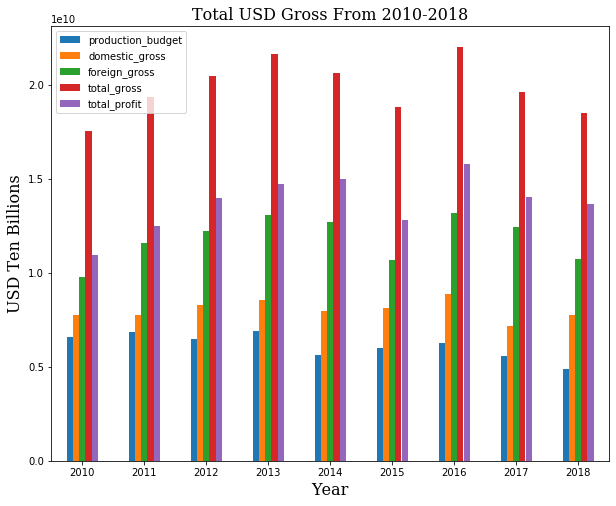

In [25]:
font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }
tots.plot(kind = "bar", figsize = (10,8))
plt.ylabel("USD Ten Billions", fontdict=font)
plt.xlabel("Year", fontdict=font)
plt.title("Total USD Gross From 2010-2018", fontdict=font);
plt.xticks(rotation=0)
plt.savefig('../images/total_gross_2010_2018.png', bbox_inches = "tight");



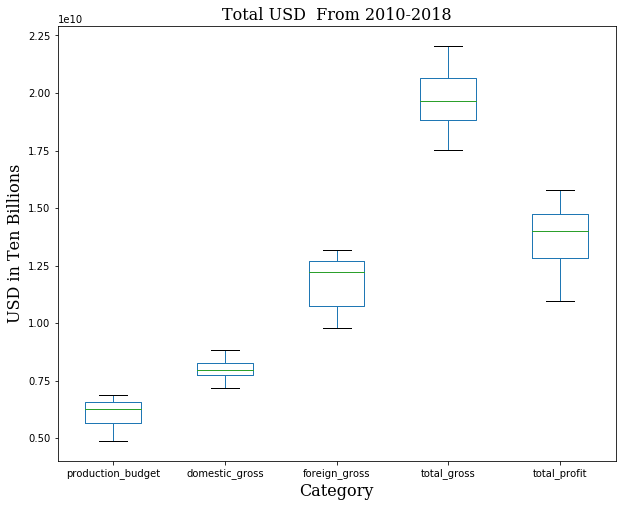

In [26]:
# Range of each money category


tots.plot(kind = "box", figsize = (10,8))
plt.ylabel("USD in Ten Billions", fontdict=font)
plt.xlabel("Category", fontdict=font)
plt.title("Total USD  From 2010-2018", fontdict=font);
plt.savefig('../images/total_gross_boxplot_2010_2018.png', bbox_inches = "tight");

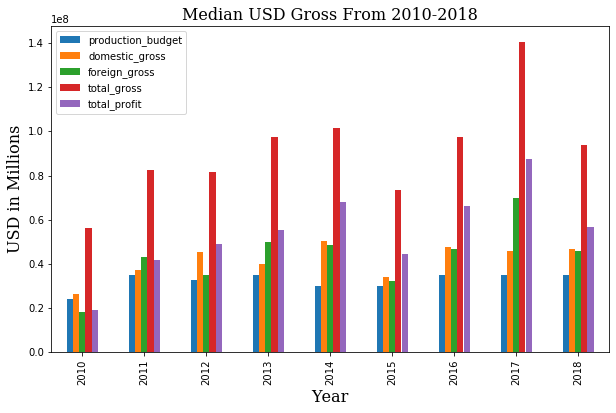

In [27]:

median_df.plot(kind = "bar", figsize = (10,6))
plt.ylabel("USD in Millions", fontdict=font)
plt.xlabel("Year", fontdict=font)
plt.title("Median USD Gross From 2010-2018", fontdict=font);
plt.savefig('../images/avg_gross_2010_2018.png', bbox_inches = "tight");

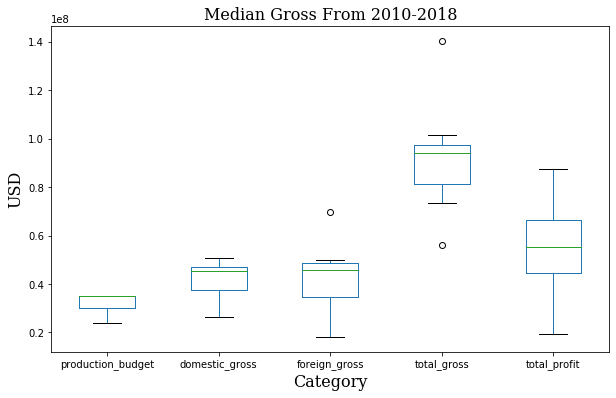

In [28]:

median_df.plot(kind = "box", figsize = (10,6))
plt.ylabel("USD", fontdict=font)
plt.xlabel("Category", fontdict=font)
plt.title("Median Gross From 2010-2018", fontdict=font);
plt.savefig('../images/avg_gross_boxplot_2010_2018.png', bbox_inches = "tight");

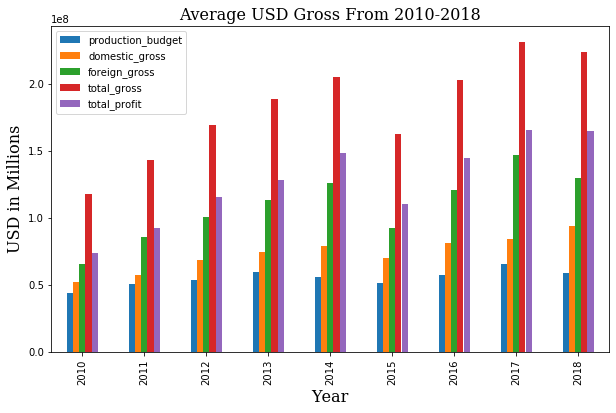

In [29]:
mean_df.plot(kind = "bar", figsize = (10,6))
plt.ylabel("USD in Millions", fontdict=font)
plt.xlabel("Year", fontdict=font)
plt.title("Average USD Gross From 2010-2018", fontdict=font);
plt.savefig('../images/avg_gross_2010_2018.png', bbox_inches = "tight");

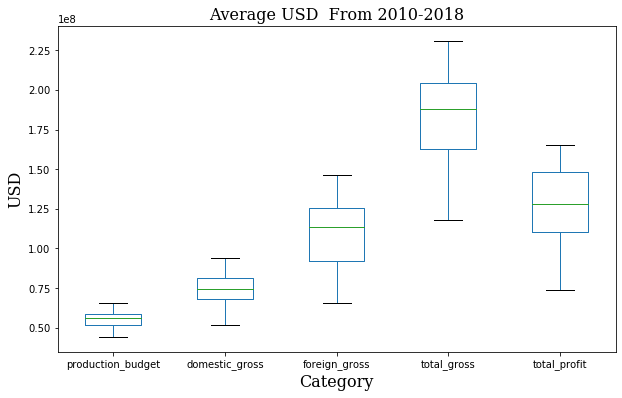

In [30]:
mean_df.plot(kind = "box", figsize = (10,6))
plt.ylabel("USD", fontdict=font)
plt.xlabel("Category", fontdict=font)
plt.title("Average USD  From 2010-2018", fontdict=font);
plt.savefig('../images/avg_gross_boxplot_2010_2018.png', bbox_inches = "tight");

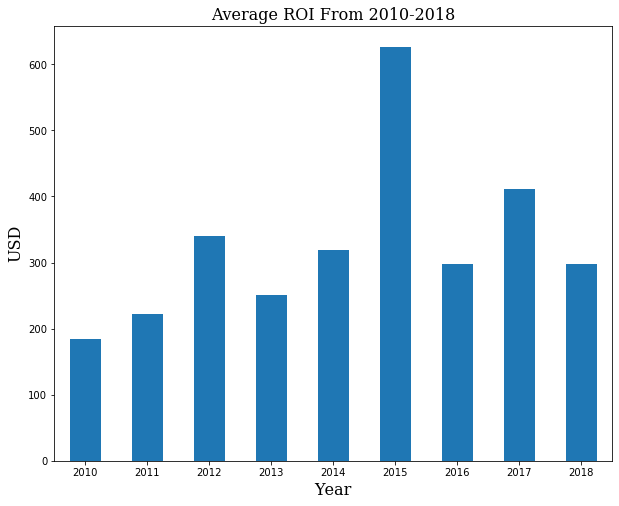

In [31]:
font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }
roi_df.plot(kind = "bar", figsize = (10,8))
plt.ylabel("USD", fontdict=font)
plt.xlabel("Year", fontdict=font)
plt.title("Average ROI From 2010-2018", fontdict=font);
plt.xticks(rotation=0)
plt.savefig('../images/total_gross_2010_2018.png', bbox_inches = "tight");



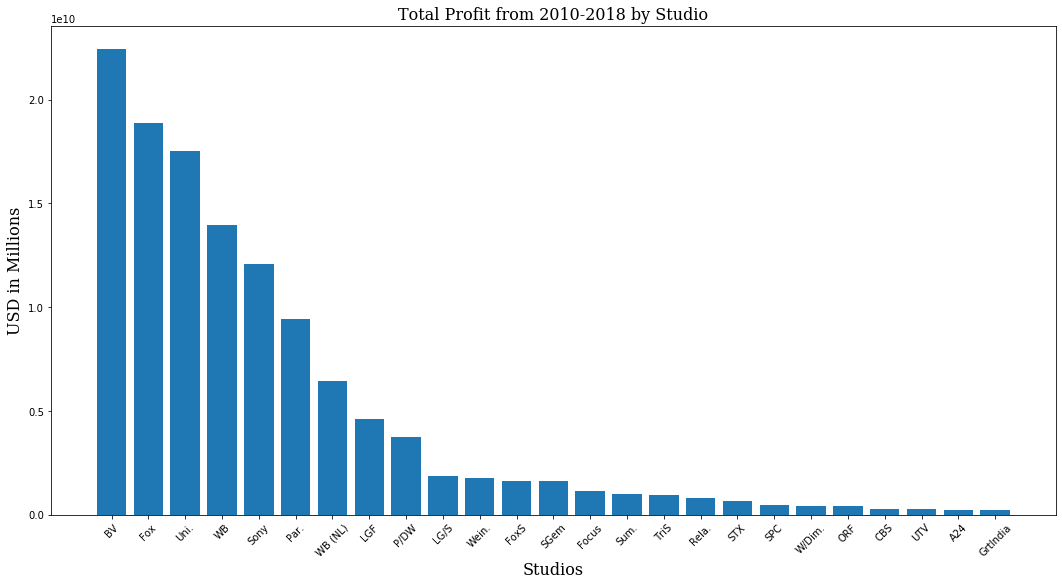

In [32]:

studio_df=movie_db.groupby("studio")["domestic_gross", "foreign_gross", "total_gross","total_profit"].sum().sort_values(by="total_profit", ascending = False)[:25]
fig, ax = plt.subplots(figsize = (18,9))

x= studio_df.index
y= studio_df["total_profit"]
ax.bar(x,y, linewidth=1)
ax.set_title("Total Profit from 2010-2018 by Studio", fontdict=font)
ax.set_ylabel("USD in Millions", fontdict=font )
ax.set_xlabel("Studios", fontdict=font)
plt.xticks(rotation=45);
#plt.ticklabel_format(style='plain', axis='y')
plt.savefig('../images/total_profit_2010_2018.png', bbox_inches = "tight");

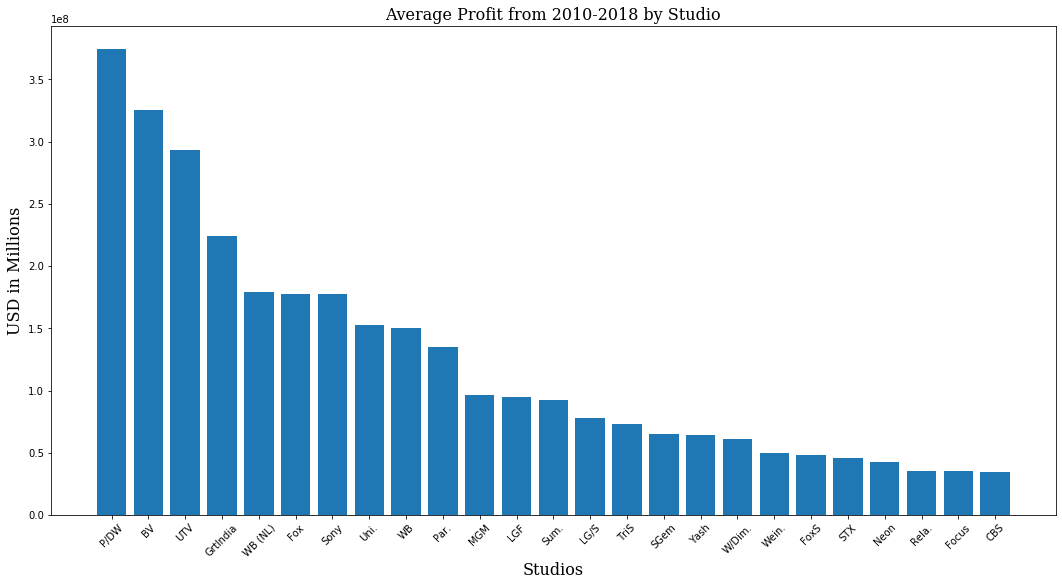

In [33]:
avg_studio_df=movie_db.groupby("studio")["domestic_gross", "foreign_gross", "total_gross","total_profit"].agg("mean").sort_values(by="total_profit", ascending = False)[:25]
fig, ax = plt.subplots(figsize = (18,9))

x= avg_studio_df.index
y= avg_studio_df["total_profit"]
ax.bar(x,y, linewidth=1)
ax.set_title("Average Profit from 2010-2018 by Studio", fontdict=font)
ax.set_ylabel("USD in Millions", fontdict=font )
ax.set_xlabel("Studios", fontdict=font)
plt.xticks(rotation=45);
#plt.ticklabel_format(style='plain', axis='y')
plt.savefig('../images/avg_total_profit_2010_2018.png', bbox_inches = "tight");

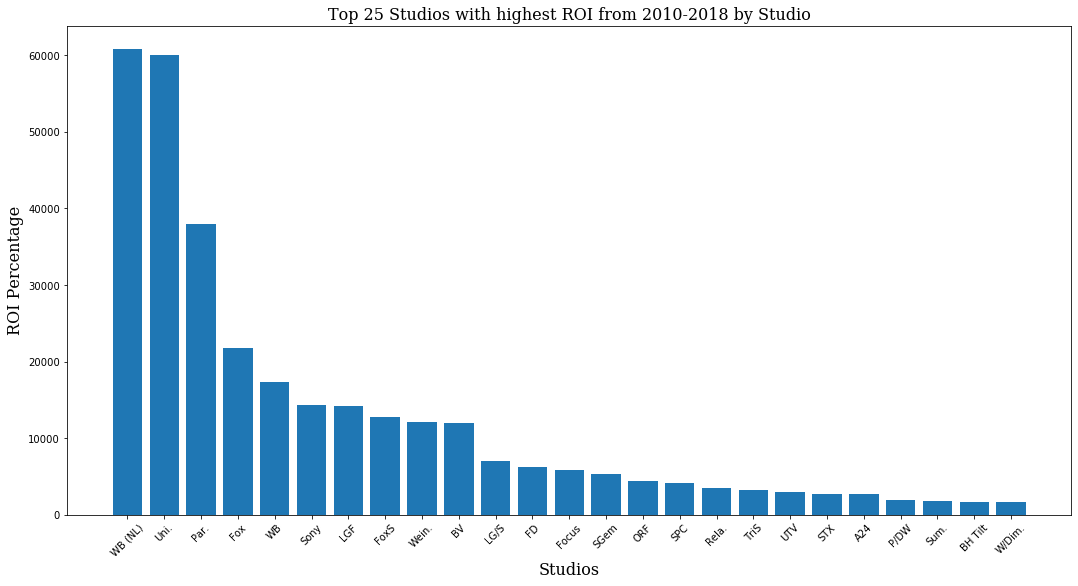

In [34]:
studio_df=movie_db.groupby("studio")["roi_percentage", "total_gross","total_profit"].sum().sort_values(by="roi_percentage", ascending = False)[:25]
fig, ax = plt.subplots(figsize = (18,9))

x= studio_df.index
y= studio_df["roi_percentage"]
ax.bar(x,y, linewidth=1)
ax.set_title("Top 25 Studios with highest ROI from 2010-2018 by Studio", fontdict=font)
ax.set_ylabel("ROI Percentage", fontdict=font )
ax.set_xlabel("Studios", fontdict=font)
plt.xticks(rotation=45);
#plt.ticklabel_format(style='plain', axis='y')
plt.savefig('../images/roi_2010_2018.png', bbox_inches = "tight");

In [35]:
#df.set_index("title")
movie_db.head(2)

,title,studio,domestic_gross,foreign_gross,year,original_language,popularity,release_date,vote_average,vote_count,production_budget,total_gross,total_profit,roi_percentage
0,Toy Story 3,BV,415000000.0,652000000.0,2010,en,24.445,2010-06-17,7.7,8340,200000000,1.067000e+09,867000000.0,400.0
1,Inception,WB,292600000.0,535700000.0,2010,en,27.920,2010-07-16,8.3,22186,160000000,8.283000e+08,668300000.0,400.0


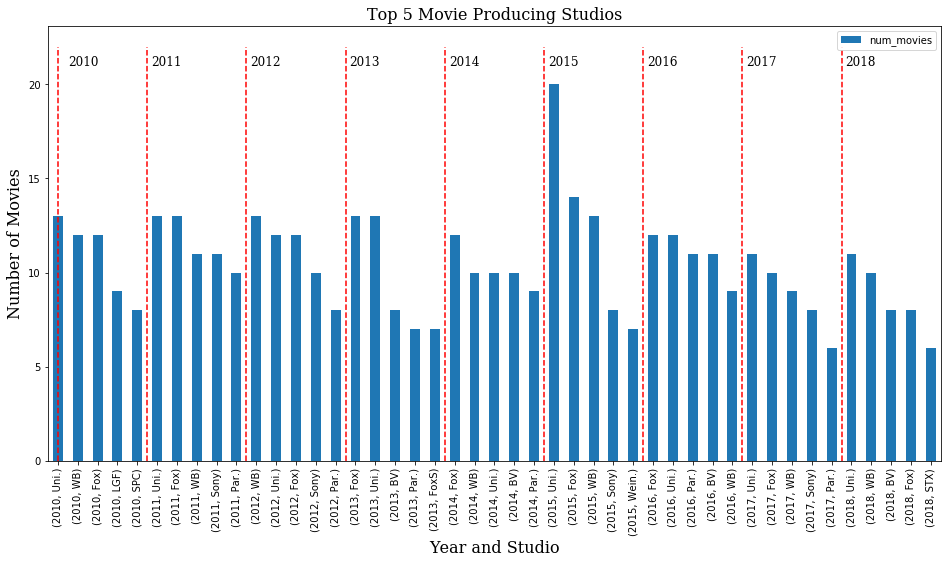

In [36]:
#changing the df.groupby series into a multiindex dataframe
DJB=pd.DataFrame(movie_db.groupby(["year"])["studio"].value_counts(ascending = False))
DJB.rename(columns={"studio":"num_movies"}, inplace = True)

font4 = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 12,
        }

top_5studio_per_year = DJB.groupby(level=[0]).apply(lambda x:x.groupby(level=[1]).sum().sort_values('num_movies',ascending=False).head(5))
top_5studio_per_year.plot(kind= "bar", figsize = (16,8))

plt.title("Top 5 Movie Producing Studios", fontdict=font)
plt.xlabel("Year and Studio", fontdict=font)
plt.ylabel("Number of Movies", fontdict=font);
plt.vlines([0,4.5,9.5,14.5,19.5,24.5,29.5,34.5,39.5],0,22,color="red",linestyles="dashed");
plt.text(0.5,21,'2010',rotation=0, fontdict=font4)
plt.text(4.7,21,'2011',rotation=0, fontdict=font4)
plt.text(9.7,21,'2012',rotation=0, fontdict=font4)
plt.text(14.7,21,'2013',rotation=0, fontdict=font4)
plt.text(19.7,21,'2014',rotation=0, fontdict=font4)
plt.text(24.7,21,'2015',rotation=0, fontdict=font4)
plt.text(29.7,21,'2016',rotation=0, fontdict=font4)
plt.text(34.7,21,'2017',rotation=0, fontdict=font4)
plt.text(39.7,21,'2018',rotation=0, fontdict=font4)
plt.legend(loc = 1);
plt.savefig('../images/top5_producers.png', bbox_inches = "tight");

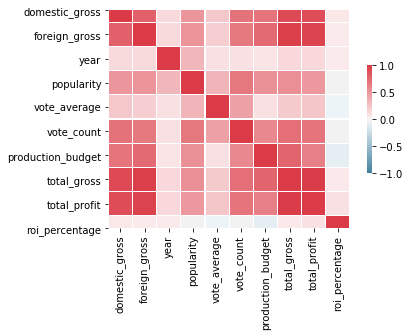

In [37]:
cmap = sns.diverging_palette(230, 10, as_cmap=True)
# Try scatter plot between domestic and foreign 
sns.heatmap(movie_db.corr(), cmap=cmap, vmin = -1, vmax=1, 
            center=0, linewidths=.1, square = True, cbar_kws={"shrink": .5});
plt.savefig('../images/heatmap_movie_db.png', bbox_inches = "tight");

In [38]:
# Pixar/DreamWorks made the most average money ... 
# but it is not the highest movie releasing making studio each year... 
# what are they doing right or are they doing it right? 
# we will be checking the roi for their movies. 

In [39]:
# locating all movies made by Pixar/DrewamWorks(P/DW)
pdw=movie_db.loc[movie_db["studio"]== "P/DW"]
# making a pwd movie list
pdw_movie_list=pdw.groupby(["year"])["title"].value_counts(ascending = False)

In [40]:
pdw_movie_list
#The database only has 10 movies from Pixar/DreamWorks

year  title                             
2010  Dinner for Schmucks                   1
      How to Train Your Dragon              1
      Megamind                              1
      Shrek Forever After                   1
2011  Kung Fu Panda 2                       1
      Puss in Boots                         1
      Transformers: Dark of the Moon        1
2012  A Thousand Words                      1
      Madagascar 3: Europe's Most Wanted    1
      Rise of the Guardians                 1
Name: title, dtype: int64

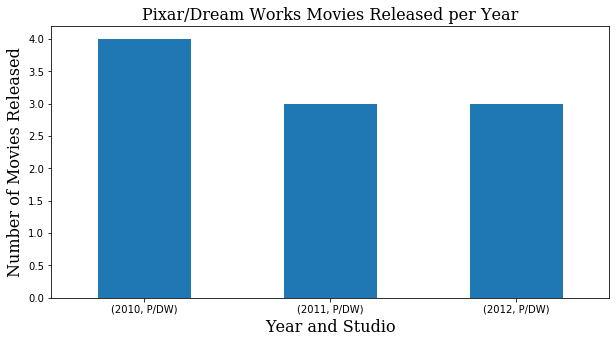

In [41]:
# Amount of movies released in a given year from P/DW
pdw_movies=pdw.groupby(["year"])["studio"].value_counts(ascending = False)
pdw_movies.plot(kind="bar", figsize = (10,5))
plt.xticks(rotation=0)
plt.ylabel("Number of Movies Released", fontdict=font)
plt.xlabel("Year and Studio", fontdict = font)
plt.title("Pixar/Dream Works Movies Released per Year", fontdict=font);
plt.savefig('../images/pixar_wd_movies_released.png', bbox_inches = "tight");

In [42]:
# Recheck if total_profit is working

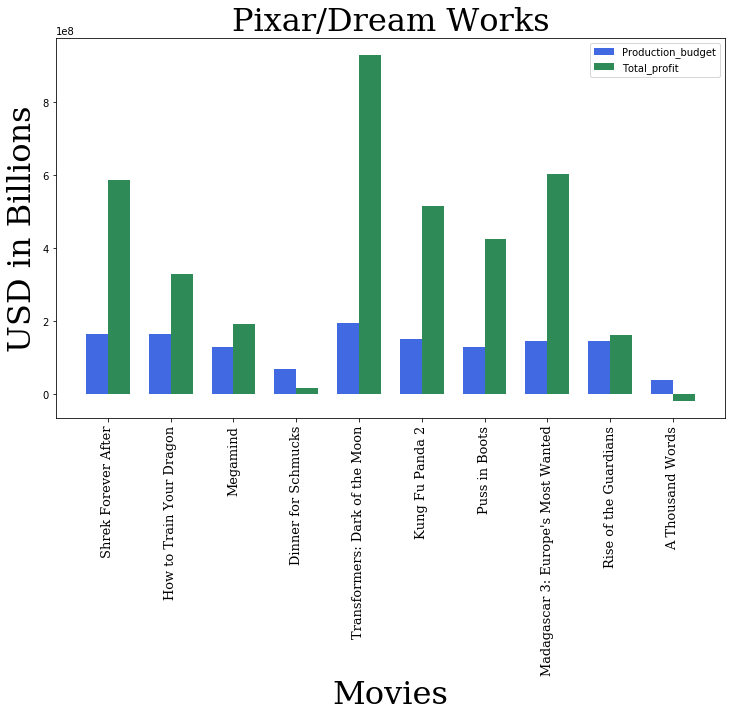

<Figure size 432x288 with 0 Axes>

In [43]:
font2 = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 32,
        }

font3 = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 13,
        }
N = 10
x = pdw['title']
y2 = pdw['total_profit']
y1 = pdw['production_budget']

ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

fig = plt.figure(figsize=(12,7)) 
ax = fig.add_subplot()
budget = ax.bar(ind, y1, width, color='royalblue')
total = ax.bar(ind+width, y2, width, color='seagreen')

ax.set_ylabel('USD in Billions',fontdict = font2)
ax.set_title("Pixar/Dream Works", fontdict = font2)
ax.set_xticks(ind + width / 2)
plt.xticks(rotation = 90)
ax.set_xticklabels(x, fontdict = font3)
ax.set_xlabel("Movies", fontdict = font2)
ax.legend((budget[0], total[0]), ('Production_budget', 'Total_profit'))
plt.show();
plt.savefig('../images/pixar_dw_movies.png', bbox_inches = "tight");

In [44]:
bv=movie_db.loc[movie_db["studio"]== "BV"]

In [45]:
bv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69 entries, 0 to 1308
Data columns (total 14 columns):
title                69 non-null object
studio               69 non-null object
domestic_gross       69 non-null float64
foreign_gross        69 non-null float64
year                 69 non-null int64
original_language    69 non-null object
popularity           69 non-null float64
release_date         69 non-null object
vote_average         69 non-null float64
vote_count           69 non-null int64
production_budget    69 non-null int64
total_gross          69 non-null float64
total_profit         69 non-null float64
roi_percentage       69 non-null float64
dtypes: float64(7), int64(3), object(4)
memory usage: 8.1+ KB


In [46]:
bv["production_budget"]=bv["production_budget"].astype(float)

In [47]:
bv_movie_list=bv.groupby(["year"])["title"].value_counts(ascending = False)

In [48]:
bv_movie_list

year  title                             
2010  Oceans                                1
      Secretariat                           1
      Tangled                               1
      The Last Song                         1
      The Sorcerer's Apprentice             1
                                           ..
2018  Black Panther                         1
      Incredibles 2                         1
      Mary Poppins Returns                  1
      Solo: A Star Wars Story               1
      The Nutcracker and the Four Realms    1
Name: title, Length: 69, dtype: int64

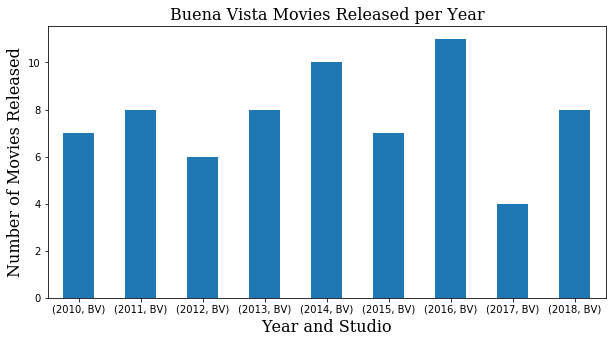

In [49]:
bv_movies=bv.groupby(["year"])["studio"].value_counts(ascending = False)
bv_movies.plot(kind="bar", figsize = (10,5))
plt.xticks(rotation=0)
plt.ylabel("Number of Movies Released", fontdict = font)
plt.title("Buena Vista Movies Released per Year", fontdict = font)
plt.xlabel("Year and Studio", fontdict = font);
plt.savefig('../images/bv_movies_released.png', bbox_inches = "tight");

In [50]:
bv_25=bv.sort_values("total_profit", ascending = False)[:25]

In [51]:
bv_25.shape

(25, 14)

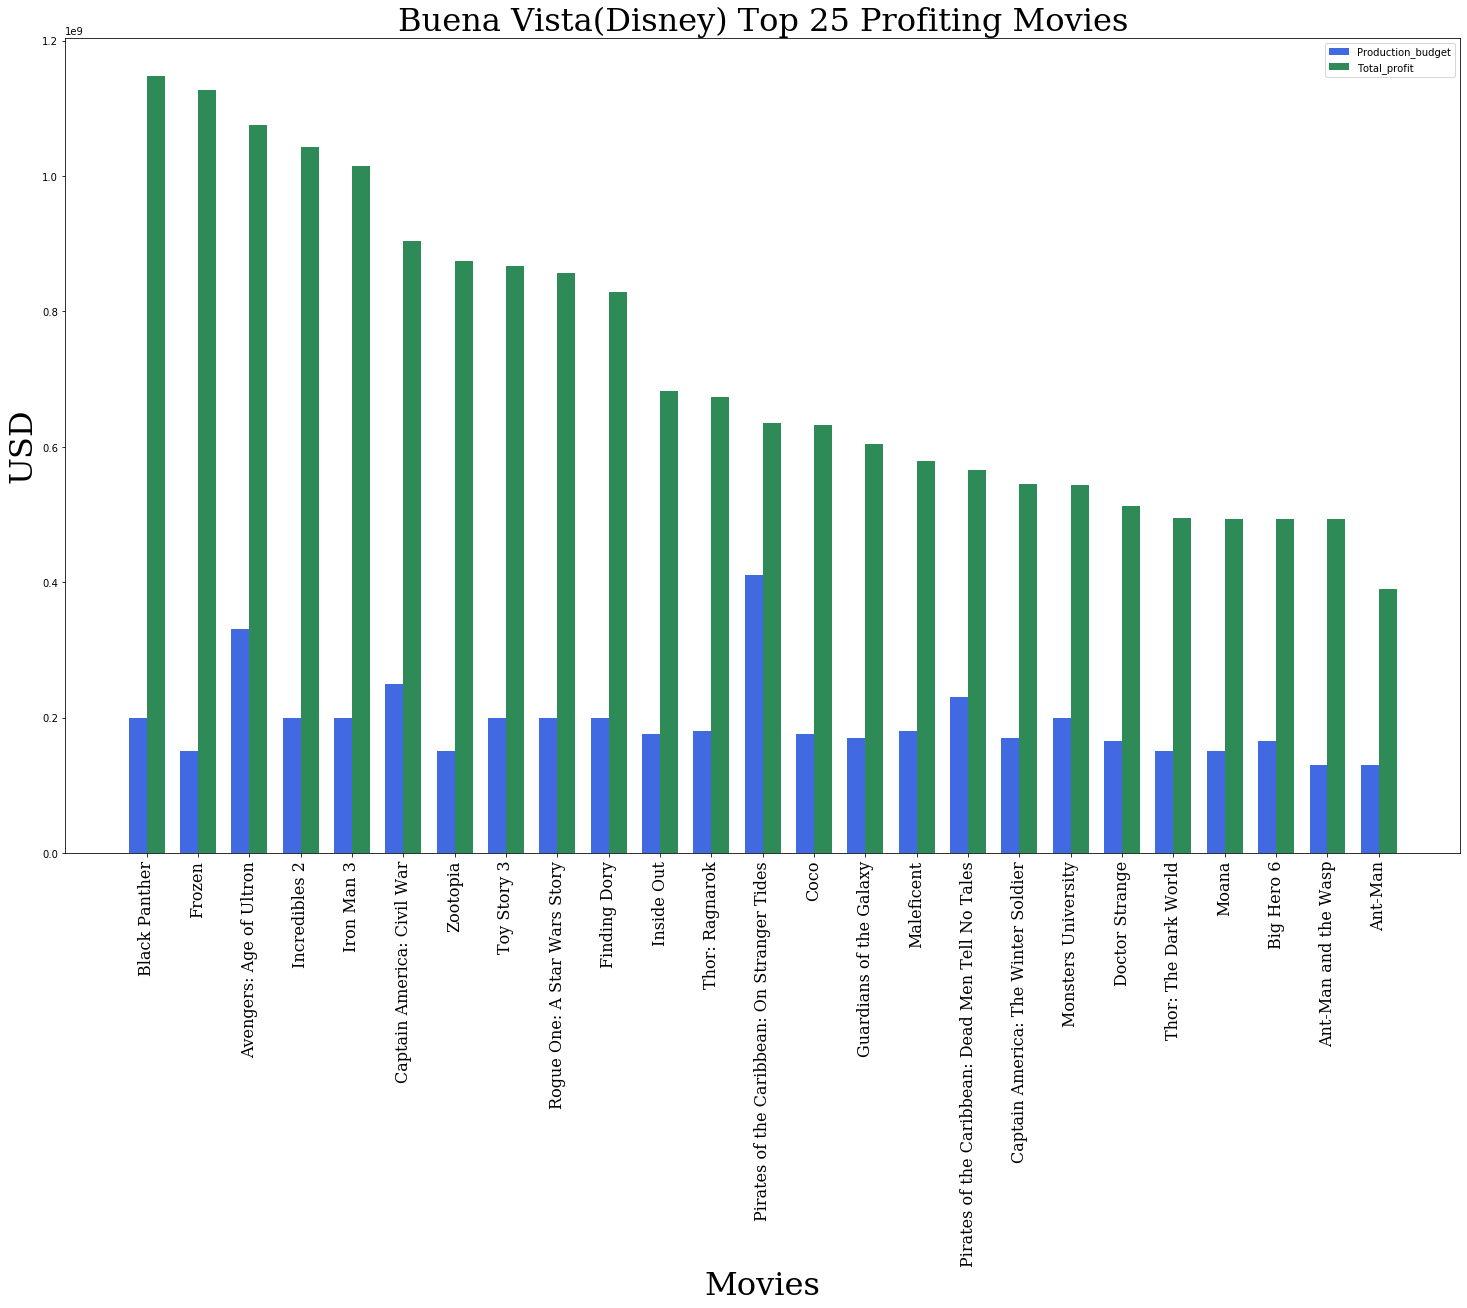

<Figure size 432x288 with 0 Axes>

In [52]:
font2 = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 32,
        }

font3 = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }
N = 25
x = bv_25['title']
y2 = bv_25['total_profit']
y1 = bv_25['production_budget']
r = bv_25["roi_percentage"]
ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

fig = plt.figure(figsize=(25,15))
ax = fig.add_subplot(111)
budget = ax.bar(ind, y1, width, color='royalblue')
total = ax.bar(ind+width, y2, width, color='seagreen')

ax.set_ylabel('USD', fontdict = font2)
ax.set_title("Buena Vista(Disney) Top 25 Profiting Movies", fontdict = font2)
ax.set_xticks(ind + width / 2)
plt.xticks(rotation = 90)
ax.set_xticklabels(x, fontdict = font3)
ax.set_xlabel("Movies", fontdict = font2)

ax.legend( (budget[0], total[0]), ('Production_budget', 'Total_profit') )

plt.show();
plt.savefig('../images/bv_top25_movies.png', bbox_inches = "tight");

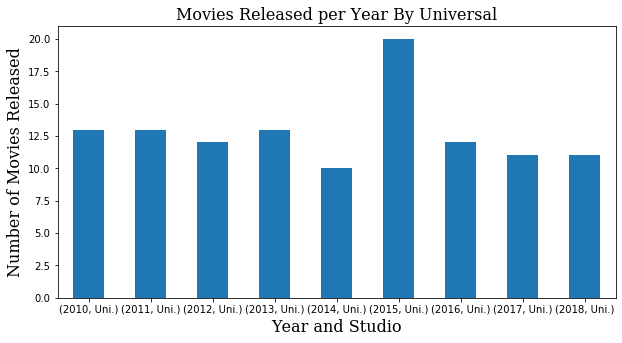

In [53]:
# Searching all titles released by Uni. from 2010-2018 and looking at the amoutn of movies released by year.
uni=movie_db.loc[movie_db["studio"] == "Uni."]

uni_movies=uni.groupby(["year"])["studio"].value_counts(ascending = False)

uni_movies.plot(kind="bar", figsize = (10,5))
plt.xticks(rotation=0)
plt.ylabel("Number of Movies Released", fontdict = font)
plt.title("Movies Released per Year By Universal", fontdict = font)
plt.xlabel("Year and Studio", fontdict = font);
plt.savefig('../images/universal_movies_released.png', bbox_inches = "tight");

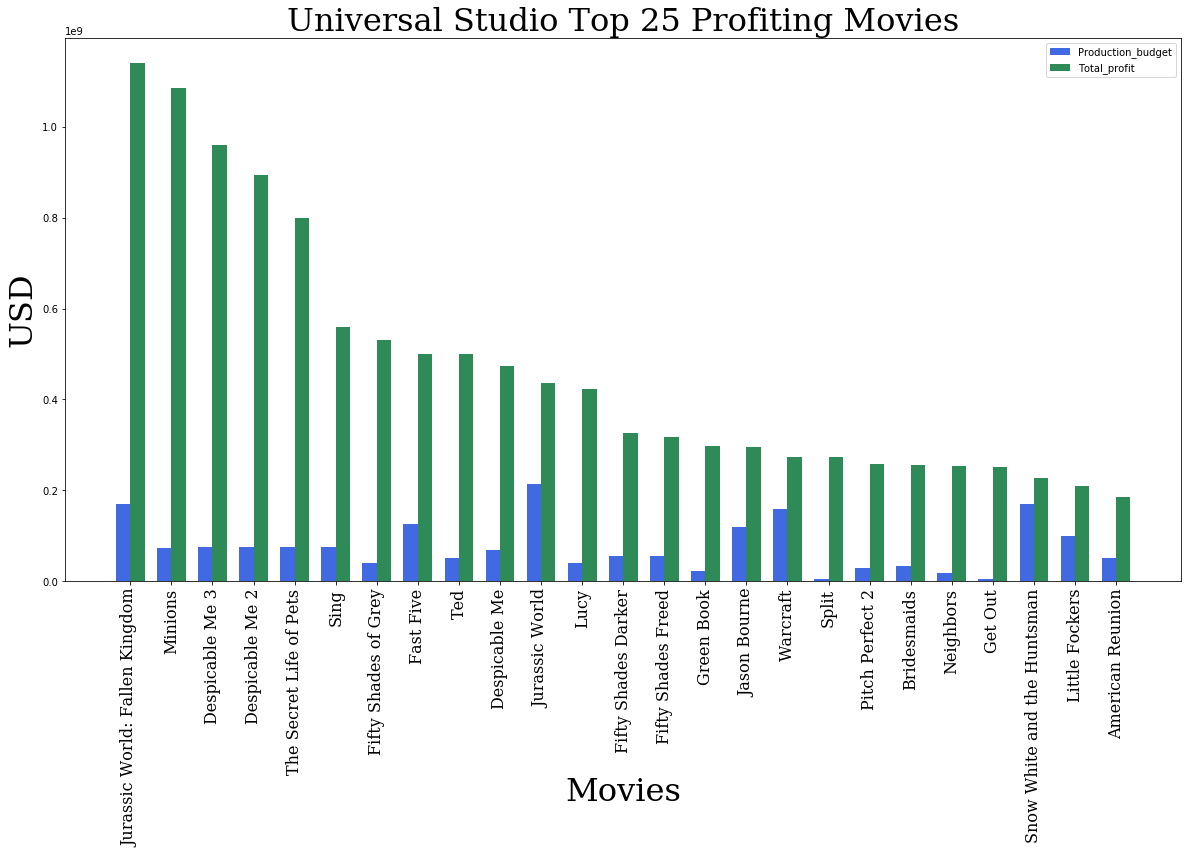

<Figure size 432x288 with 0 Axes>

In [64]:
#looking at the amount of movies released by year
uni_25=uni.sort_values("total_profit", ascending = False)[:25]
N = 25
x = uni_25['title']
y2 = uni_25['total_profit']
y1 = uni_25['production_budget']

ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

fig = plt.figure(figsize=(20,10));
ax = fig.add_subplot(111)
budget = ax.bar(ind, y1, width, color='royalblue')
total = ax.bar(ind+width, y2, width, color='seagreen')

ax.set_ylabel('USD', fontdict = font2);
ax.set_title("Universal Studio Top 25 Profiting Movies", fontdict = font2);
ax.set_xticks(ind + width / 2)
plt.xticks(rotation = 90);
ax.set_xticklabels(x, fontdict = font3)
ax.set_xlabel("Movies", fontdict = font2, labelpad = -70)

ax.legend((budget[0], total[0]), ('Production_budget', 'Total_profit'));

plt.show();
plt.savefig('../images/universal_top25_movies.png', bbox_inches = "tight");

In [55]:
popularity_max=movie_db.loc[movie_db["popularity"]== 80.773]
vote_count_max=movie_db.loc[movie_db["vote_count"] == 22186]
gross_max = movie_db.loc[movie_db["total_gross"] == 1405400000.0]
profit_max = movie_db.loc[movie_db["total_profit"] == 1147000000.0]
best_performing = vote_count_max.append(gross_max)
best_performing = best_performing.append(profit_max)
best_performing = best_performing.append(popularity_max)
best_performing.set_index("title", inplace = True)
bp_money = best_performing[["production_budget","total_gross", "total_profit"]]
bp_pop= best_performing[["popularity"]]
bp_sub = best_performing[["vote_average"]]


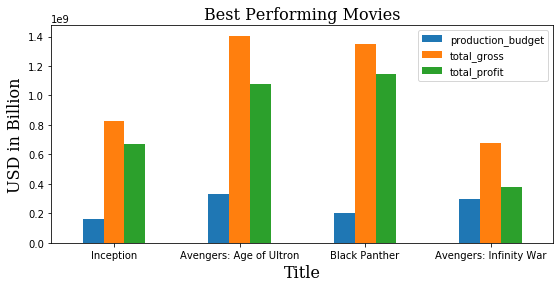

In [56]:
bp_money.plot(kind="bar", figsize = (9,4))
plt.title("Best Performing Movies", fontdict=font3)
plt.xlabel("Title", fontdict=font3)
plt.ylabel("USD in Billion", fontdict=font3)
plt.xticks(rotation = 0);
plt.savefig('../images/best_performing_movies.png', bbox_inches = "tight");

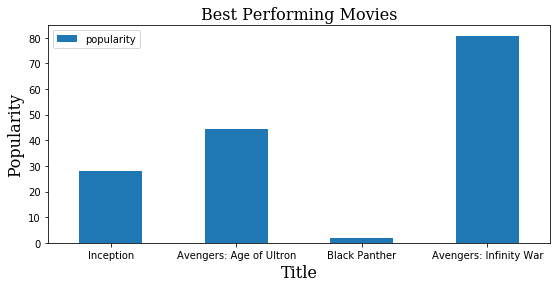

In [57]:
bp_pop.plot(kind="bar", figsize = (9,4))
plt.title("Best Performing Movies", fontdict=font3)
plt.xlabel("Title", fontdict=font3)
plt.ylabel("Popularity", fontdict=font3)
plt.xticks(rotation = 0);
plt.savefig('../images/bp_popularity.png', bbox_inches = "tight");

In [58]:
uni_movies=uni.groupby(["year"])["studio"].value_counts(ascending = False)

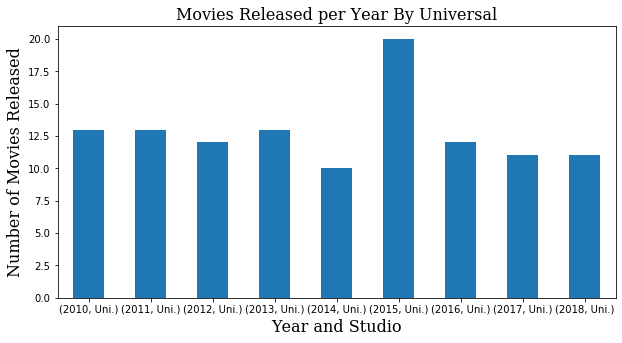

In [59]:
uni_movies.plot(kind="bar", figsize = (10,5))
plt.xticks(rotation=0)
plt.ylabel("Number of Movies Released", fontdict = font)
plt.title("Movies Released per Year By Universal", fontdict = font)
plt.xlabel("Year and Studio", fontdict = font);
plt.savefig('../images/universal_movies_released.png', bbox_inches = "tight");

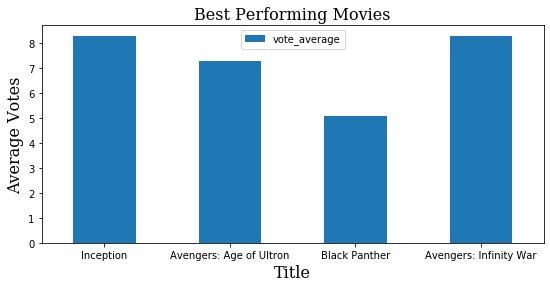

In [60]:
bp_sub.plot(kind="bar", figsize = (9,4))
plt.title("Best Performing Movies", fontdict=font3)
plt.xlabel("Title", fontdict=font3)
plt.ylabel("Average Votes", fontdict=font3)
plt.xticks(rotation = 0);
plt.savefig('../images/bp_avg_votes.png', bbox_inches = "tight");

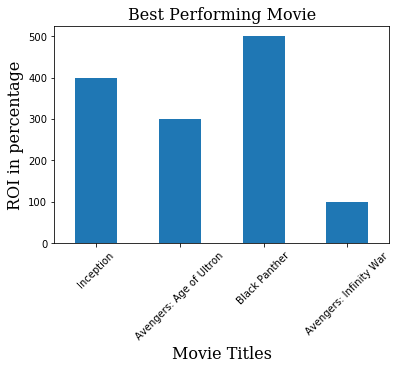

In [61]:
best_performing.roi_percentage.plot(kind = "bar")

plt.title("Best Performing Movie", fontdict = font)
plt.ylabel("ROI in percentage", fontdict = font)
plt.xlabel("Movie Titles", fontdict = font)
plt.xticks(rotation = 45);

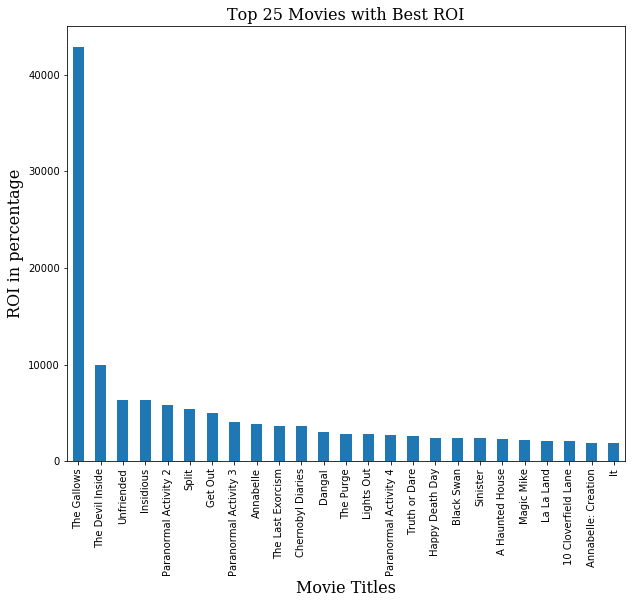

In [62]:
movie_db.set_index("title", inplace = True)

best_roi=movie_db["roi_percentage"].sort_values(ascending=False)[:25]

best_roi.plot(kind="bar", figsize = (10,8))
plt.title("Top 25 Movies with Best ROI", fontdict = font)
plt.ylabel("ROI in percentage", fontdict = font)
plt.xlabel("Movie Titles", fontdict = font);